Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot intrepret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for maching learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a dataframe and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the data science team at the BBC. We want to recommend articles to visiters to on the BBC website based on the article they just read.

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearences of words, does the word appear at all (binary), and term-frequency inverse-document frequence (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

In [1]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [2]:
text = '''We created a new dataset which emphasizes diversity of content, by scraping content from the Internet. 
In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, 
we used outbound links from Reddit which received at least 3 karma. This can be thought of as a heuristic indicator 
for whether other users found the link interesting (whether educational or funny), leading to higher data quality than 
other similar datasets, such as CommonCrawl.'''

In [3]:
doc = nlp(text)
print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['create', 'new', 'dataset', 'emphasize', 'diversity', 'content', 'scrape', 'content', 'internet', '\n', 'order', 'preserve', 'document', 'quality', 'page', 'curate', 'filter', 'human', 'specifically', '\n', 'outbound', 'link', 'Reddit', 'receive', '3', 'karma', 'think', 'heuristic', 'indicator', '\n', 'user', 'find', 'link', 'interesting', 'educational', 'funny', 'lead', 'high', 'datum', 'quality', '\n', 'similar', 'dataset', 'CommonCrawl']


In [4]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt':
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [5]:
data = gather_data('./data')

In [6]:
data[0]

b'Intel unveils laser breakthrough\n\nIntel has said it has found a way to put a silicon-based laser on a chip, raising hopes of much faster networks.\n\nScientists at Intel have overcome a fundamental problem that before now has prevented silicon being used to generate and amplify laser light. The breakthrough should make it easier to interconnect data networks with the chips that process the information. The Intel researchers said products exploiting the breakthrough should appear by the end of the decade.\n\n"We\'ve overcome a fundamental limit," said Dr Mario Paniccia, director of Intel\'s photonics technology lab. Writing in the journal Nature, Dr Paniccia - and colleagues Haisheng Rong, Richard Jones, Ansheng Liu, Oded Cohen, Dani Hak and Alexander Fang - show how they have made a continuous laser from the same material used to make computer processors. Currently, says Dr Paniccia, telecommunications equipment that amplifies the laser light that travels down fibre optic cables is

In [7]:
len(data)

401

### CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
        "In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
        "This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(text)

# transform text
# document term matrix
dtm = vect.transform(text)
print(dtm.shape)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.
# The vocabulary dictionary does not represent the counts of words!!

(3, 61)


In [9]:
print(vect.get_feature_names())

['as', 'at', 'be', 'been', 'by', 'can', 'commoncrawl', 'content', 'created', 'curated', 'data', 'dataset', 'datasets', 'diversity', 'document', 'educational', 'emphasizes', 'filtered', 'for', 'found', 'from', 'funny', 'have', 'heuristic', 'higher', 'humans', 'in', 'indicator', 'interesting', 'internet', 'karma', 'leading', 'least', 'link', 'links', 'new', 'of', 'only', 'or', 'order', 'other', 'outbound', 'pages', 'preserve', 'quality', 'received', 'reddit', 'scraping', 'similar', 'specifically', 'such', 'than', 'the', 'this', 'thought', 'to', 'used', 'users', 'we', 'whether', 'which']


In [10]:
text

['We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.',
 'In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.',
 'This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl.']

In [11]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [12]:
print(dtm)

  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (1, 9)	1
  (1, 14)	1
  (1, 17)	1
  (1, 20)	1
  (1, 22)	1
  (1, 25)	1
  (1, 26)	1
  (1, 30)	1
  :	:
  (2, 10)	1
  (2, 12)	1
  (2, 15)	1
  (2, 18)	1
  (2, 19)	1
  (2, 21)	1
  (2, 23)	1
  (2, 24)	1
  (2, 27)	1
  (2, 28)	1
  (2, 31)	1
  (2, 33)	1
  (2, 36)	1
  (2, 38)	1
  (2, 40)	2
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 52)	1
  (2, 53)	1
  (2, 54)	1
  (2, 55)	1
  (2, 57)	1
  (2, 59)	2


In [13]:
# Dealing with Sparse Matrix
dtm.todense()

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2],
        [2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0]])

In [14]:
# Get Word Counts for each document
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,as,at,be,been,by,can,commoncrawl,content,created,curated,...,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,...,0,1,0,0,0,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,2,0,2,0,2
2,2,0,1,0,0,1,1,0,0,0,...,1,1,1,1,1,0,1,0,2,0


In [15]:
text[0]

'We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.'

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [16]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vect = CountVectorizer(stop_words='english')

# Fit the vectorizer to learn vocab and transform the data into dtm
dtm = vect.fit_transform(data)

# Convert the dtm to pandas dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(dtm.shape)
dtm.head()

(401, 11820)


,00,000,000s,0051,007,01,028,04m,05,0530,...,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
import seaborn as sns
sns.set()

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    
    # Arguments
        samples_texts: list, sample texts.
    """
    num_words = [len(s.split()) for s in sample_texts]
    
    plt.figure(figsize=(8,6))
    sns.distplot(num_words)
    plt.title('Number of Words per Document', fontsize=14)
    plt.xlabel('Number of Words', fontsize=12)
    plt.ylabel('Proportion of documents', fontsize=12)
    plt.show()

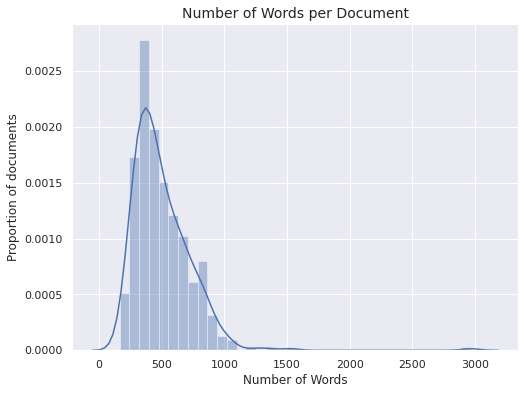

In [19]:
plot_sample_length_distribution(data)

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

In [20]:
text[0]

'We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.'

In [21]:
len(text[0].split())

16

In [22]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english',
                        # tokenizer = tokenize,
                        ngram_range = (1,2),
                        min_df = 3, 
                        max_df = 0.6,
                        max_features = 5000)

# Create a vocabulary and tf-idf score per document
dtm = tfidf.fit_transform(data)

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(401, 5000)


,000,000 000,000 broadband,000 copies,000 new,000 people,000 times,000 units,10,10 000,...,york state,york times,young,young americans,young people,younger,youngsters,youth,zen,zombies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017115,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040679,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


text data machines

"text data" "data machines"

## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [29]:
# Calculate Distance of TF-IDF Vectors
from sklearn.metrics.pairwise import cosine_similarity

dist_matrix  = cosine_similarity(dtm)

In [30]:
# Turn it into a DataFrame
df = pd.DataFrame(dist_matrix)
print(df.shape)
df.head()

(401, 401)


,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.013493,0.005590,0.030654,0.011834,0.035149,0.029051,0.012324,0.010754,0.009516,...,0.022547,0.011478,0.010224,0.041036,0.015482,0.029821,0.002260,0.074191,0.004381,0.024373
1,0.013493,1.000000,0.039448,0.043848,0.019808,0.024922,0.020477,0.017888,0.044150,0.020121,...,0.022139,0.015575,0.064060,0.026371,0.016529,0.054696,0.001376,0.025406,0.007716,0.028991
2,0.005590,0.039448,1.000000,0.038853,0.003269,0.021081,0.034207,0.013299,0.008598,0.018835,...,0.023506,0.037670,0.017480,0.029438,0.030841,0.041505,0.016153,0.024390,0.032176,0.013409
3,0.030654,0.043848,0.038853,1.000000,0.041661,0.026733,0.095330,0.172145,0.045367,0.123469,...,0.082746,0.031393,0.053445,0.064806,0.023174,0.091944,0.009883,0.062548,0.005865,0.037615
4,0.011834,0.019808,0.003269,0.041661,1.000000,0.023001,0.047243,0.014979,0.020622,0.034224,...,0.029531,0.010166,0.013056,0.027570,0.028578,0.026051,0.018473,0.006885,0.006389,0.009618


In [31]:
# Each row is the similarity of one document to all other documents (including itself)
df[0][:5]

0    1.000000
1    0.013493
2    0.005590
3    0.030654
4    0.011834
Name: 0, dtype: float64

In [32]:
# Grab the top 5 most similar documents to document 0
df[df[0] < 1][0].sort_values(ascending=False)[:5]

240    0.992427
381    0.241968
52     0.137364
225    0.104425
142    0.103310
Name: 0, dtype: float64

In [33]:
print(data[0][:150])

b'Intel unveils laser breakthrough\n\nIntel has said it has found a way to put a silicon-based laser on a chip, raising hopes of much faster networks.\n\nSc'


In [34]:
print(data[332][:150])

b"China 'blocks Google news site'\n\nChina has been accused of blocking access to Google News by the media watchdog, Reporters Without Borders.\n\nThe Paris"


### NearestNeighbor (K-NN) 

To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. The basic idea is that if point  is very distant from point , and point  is very close to point , then we know that points  and  are very distant, without having to explicitly calculate their distance. In this way, the computational cost of a nearest neighbors search can be reduced to  or better. This is a significant improvement over brute-force for large data.

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid  and radius , such that each point in the node lies within the hyper-sphere defined by  and . The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

In [40]:
dtm.head()

,000,000 000,000 broadband,000 copies,000 new,000 people,000 times,000 units,10,10 000,...,york state,york times,young,young americans,young people,younger,youngsters,youth,zen,zombies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017115,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040679,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [42]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 0.12306862, 1.23128512, 1.31349614, 1.33833855]]),
 array([[  0, 240, 381,  52, 225]]))

In [43]:
data[0][:150]

b'Intel unveils laser breakthrough\n\nIntel has said it has found a way to put a silicon-based laser on a chip, raising hopes of much faster networks.\n\nSc'

In [44]:
data[332][:150]

b"China 'blocks Google news site'\n\nChina has been accused of blocking access to Google News by the media watchdog, Reporters Without Borders.\n\nThe Paris"

In [45]:
rndm_tech_article = [ """
Zoom is implementing new security measures as it battles to prevent hackers from "zoombombing" video calls.

Trolls have been disrupting video conferences with offensive content, including racist and homophobic imagery.

Those with free Zoom accounts must use a password for all meetings.

It follows reports that a sexual assault awareness meeting on the platform was targeted by a hacker who posted a video depicting child abuse.

Zoom support meeting 'hacked' with child abuse images
Zoom meetings targeted by abuse footage sharers
Zoom has been attempting to toughen up its security measures ever since it vowed to fix its "biggest trust, safety and privacy" issues in April.

Its latest move, aimed at free users of its platform, will be implemented on 9 May.

A new level of encryption will also be introduced across the platform from 30 May, which it says will "provide increased protection for meeting data and resistance against tampering".

Jo O'Reilly, deputy editor at ProPrivacy, has suggested that Zoom still has some way to go if it is to stop large-scale companies such as Google from banning the use of the platform.

"This update may be enough to get consumers back on board," she told the BBC.

"However, if they want to turn the tide of big companies and government moving away from using Zoom, it is going to take more than superficial fixes such as enforced passwords.

"The bigger issues such as the of the lack of end-to-end encryption, making it unsuitable for commercially or politically sensitive meetings, are much trickier to solve"," added Ms O'Reilly.

Perpetrators of video-call hijackings can often be hard to identify and track down, due to the quick nature of the attacks.

Such an attack occurred on 30 April during a video conference to mark the end of Sexual Assault Awareness Month.

According to The Mercury News, a hacker posted a video depicting child abuse, and forced the meeting to end.

The community-organised event in San Francisco had been intended to allow victims of sexual assault to share their stories.

A spokesman for the District Attorney said they were aware of the matter and were looking into it.

“We are horrified about what occurred during one of our partner’s town hall events promoting Sexual Assault Awareness Month," he said.

"The intrusion further emphasises the importance of programs that combat and prevent sexual violence, including the prosecution of those who exploit children."

A spokesman for Zoom added that the platform was looking into the incident to "ensure appropriate action is taken".
"""]


In [46]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(rndm_tech_article)
new

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 119 stored elements in Compressed Sparse Row format>

In [47]:
nn.kneighbors(new.todense())

(array([[1.30936614, 1.31346171, 1.31677211, 1.32277429, 1.32546084]]),
 array([[ 58,  13, 189, 392, 268]]))

In [48]:
# Inspect Most relevant result
data[230]

b'Players sought for $1m prize\n\nUK gamers are getting a chance to take part in a $1m tournament thanks to one of the country\'s top teams.\n\nThe Four-Kings clan is staging a Pop Idol type competition to find new members who can take on the world\'s best in the lucrative tournament. Four-Kings hopes the open qualifiers will turn up gamers good enough to beat all comers at the Painkiller game. Top players also get a contract with the Four-Kings team which will pay travelling expenses for the contest.\n\nUK gamers have until 12 November to register their interest in taking part and can sign up via the Four-Kings, Jolt.co.uk and Painkiller tournament websites. Philip Wride, who co-manages the Four-Kings team, said online qualifiers will be held from 16-28 November to find the best eight players of the Painkiller game. He said the clan was running the contest because Four-Kings does not currently have any players that excel at Painkiller. These eight players will be brought together in L

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [49]:
tokens = nlp('dog cat banana asksfdsa')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 7.0336733 False
cat True 6.6808186 False
banana True 6.700014 False
asksfdsa False 0.0 True


In [50]:
# Process a word
doc = nlp("bananas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector
print(bananas_vector)

[-2.2009e-01 -3.0322e-02 -7.9859e-02 -4.6279e-01 -3.8600e-01  3.6962e-01
 -7.7178e-01 -1.1529e-01  3.3601e-02  5.6573e-01 -2.4001e-01  4.1833e-01
  1.5049e-01  3.5621e-01 -2.1508e-01 -4.2743e-01  8.1400e-02  3.3916e-01
  2.1637e-01  1.4792e-01  4.5811e-01  2.0966e-01 -3.5706e-01  2.3800e-01
  2.7971e-02 -8.4538e-01  4.1917e-01 -3.9181e-01  4.0434e-04 -1.0662e+00
  1.4591e-01  1.4643e-03  5.1277e-01  2.6072e-01  8.3785e-02  3.0340e-01
  1.8579e-01  5.9999e-02 -4.0270e-01  5.0888e-01 -1.1358e-01 -2.8854e-01
 -2.7068e-01  1.1017e-02 -2.2217e-01  6.9076e-01  3.6459e-02  3.0394e-01
  5.6989e-02  2.2733e-01 -9.9473e-02  1.5165e-01  1.3540e-01 -2.4965e-01
  9.8078e-01 -8.0492e-01  1.9326e-01  3.1128e-01  5.5390e-02 -4.2423e-01
 -1.4082e-02  1.2708e-01  1.8868e-01  5.9777e-02 -2.2215e-01 -8.3950e-01
  9.1987e-02  1.0180e-01 -3.1299e-01  5.5083e-01 -3.0717e-01  4.4201e-01
  1.2666e-01  3.7643e-01  3.2333e-01  9.5673e-02  2.5083e-01 -6.4049e-02
  4.2143e-01 -1.9375e-01  3.8026e-01  7.0883e-03 -2

In [51]:
len(bananas_vector)

300

In [52]:
# Process a text
doc = nlp("Two bananas in pyjamas")

# Get the vector for the sentence
sent_vec = doc.vector
print(sent_vec)

[ 2.07984239e-01 -2.60890484e-01 -1.15457252e-01 -1.96443751e-01
 -2.83249468e-03  3.55849974e-02 -2.05170006e-01 -2.27374747e-01
  8.56052488e-02  1.36894751e+00 -5.74124977e-02  8.06210041e-02
  2.37275064e-02  1.17454052e-01 -6.53099641e-03 -1.24400005e-01
  1.99086756e-01  6.37722552e-01  1.52916998e-01 -2.33504996e-01
 -2.40909994e-01 -7.11500049e-02 -9.10753161e-02  7.16734976e-02
  1.16262749e-01 -3.91372502e-01  1.13048747e-01 -2.11327493e-01
  1.09019078e-01 -2.44885415e-01  3.00577488e-02  4.77855802e-02
  7.37800002e-02  2.57142037e-01  2.62586236e-01 -1.66897491e-01
  1.87596500e-01 -1.23680010e-02 -1.76299751e-01  1.11685000e-01
  1.82024967e-02  9.86500084e-03 -3.58770013e-01 -2.23265499e-01
 -4.37720008e-02  3.63999486e-01  7.42954984e-02  1.21225506e-01
  1.37013003e-01 -5.50666526e-02  2.66017504e-02  8.87180045e-02
 -1.14092499e-01 -2.02865750e-01  3.63092512e-01 -3.08394760e-01
  1.13859497e-01  3.13650146e-02  2.62076259e-01  1.90399922e-02
  7.24634901e-02  2.79004

In [53]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I like dogs.")

# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.6325916466756616


In [54]:
apple = nlp('apple')
banana = nlp('banana')
car = nlp('car')
bus = nlp('bus')
tomato = nlp('tomato')
cucumber = nlp('cucumber')

print('apple vs. banana:', apple.similarity(banana))
print('car vs. banana:', car.similarity(banana))
print('car vs. bus:', car.similarity(bus))
print('tomato vs. apple:', tomato.similarity(apple))
print('tomato vs. cucumber:', tomato.similarity(cucumber))

apple vs. banana: 0.5831844567891399
car vs. banana: 0.16172661654333717
car vs. bus: 0.4816960149829203
tomato vs. apple: 0.5343438565390118
tomato vs. cucumber: 0.7295041033138109


In [55]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'suv', 'race', 'elves', 'dragon', 'sword', 'king', 'queen', 'prince', 'horse', 'fish' , 'lion', 'tiger', 'lynx', 'potato']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[ 5.15021219, -1.02589405],
       [ 4.68847306, -0.32752874],
       [ 4.18183622, -1.25490821],
       [ 2.3045236 , -0.62841121],
       [-1.6975279 , -1.26790577],
       [-2.19008419,  0.0674359 ],
       [-2.41987038, -1.23168885],
       [-2.4303113 , -2.84156896],
       [-1.9405539 , -2.55571106],
       [-2.16312982, -2.6337209 ],
       [ 0.66759362,  0.42236702],
       [-0.36687779,  4.15296085],
       [-1.89448123,  1.39241361],
       [-1.44081158,  2.52885279],
       [-0.87134078,  2.86535252],
       [ 0.42235018,  2.33795505]])

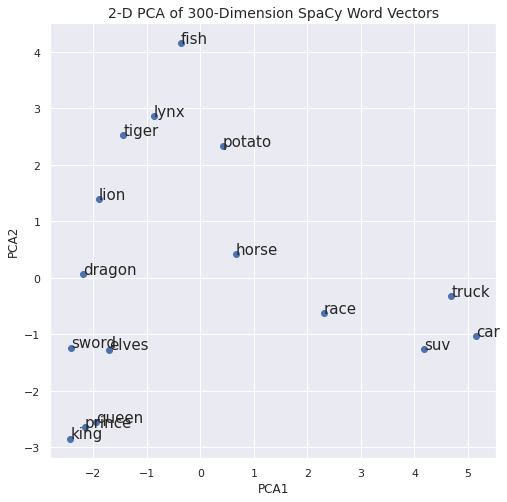

In [56]:
# create a nice big plot 
plt.figure(figsize=(8,8))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.title('2-D PCA of 300-Dimension SpaCy Word Vectors', fontsize=14)
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.show()

In [57]:
from scipy.spatial.distance import cosine

# Define vectors
king_vec = nlp("king").vector
man_vec = nlp("man").vector
woman_vec = nlp("woman").vector
queen_vec = nlp("queen").vector

# Perform vector math
result_vec = king_vec - man_vec + woman_vec

print('Cosine Similarity between (King - Man + Woman) and Queen vector:')
print(1 - cosine(queen_vec, result_vec))

Cosine Similarity between (King - Man + Woman) and Queen vector:
0.7880843877792358


## Follow Along
### Extract Document Vectors

Let's see how much the quality of our query will work when we try a new embedding model.

Steps:
* Extract Vectors from Each Document
* Search using KNN


In [58]:
X = [nlp(str(d)).vector for d in data]

In [59]:
X[0]

array([-5.26606590e-02,  1.93310201e-01, -8.77706259e-02, -2.74916086e-02,
        3.53300907e-02,  8.48217960e-03, -3.45034897e-02, -5.38188070e-02,
       -6.12878017e-02,  1.84230208e+00, -7.06735179e-02,  2.93720085e-02,
        1.26293570e-01, -3.19008306e-02, -1.53748795e-01, -1.09670430e-01,
        5.43074012e-02,  1.34866488e+00, -2.04650760e-01, -1.20139048e-01,
        7.05540776e-02, -3.06453072e-02, -8.49159956e-02, -3.69977616e-02,
       -3.34083810e-02,  3.94336395e-02, -6.37458265e-02, -5.78360260e-02,
       -2.11008247e-02, -6.21381737e-02, -6.07964769e-02,  6.31947070e-02,
       -3.51494886e-02,  7.24857152e-02,  1.07904024e-01, -8.49180967e-02,
        8.32209736e-03,  8.04125052e-03,  5.39495870e-02, -1.28336906e-01,
       -2.29684077e-03,  1.20820671e-01,  1.66694615e-02, -5.15220687e-02,
        3.46364407e-03,  1.88313294e-02, -1.05223157e-01, -7.84359202e-02,
       -6.34131059e-02,  3.20679881e-02, -7.38971867e-03,  5.02934679e-02,
       -7.46542290e-02,  

## Challenge

You will extract word embeddings from documents using Spacy's pretrained model in the upcoming module project. 

# Review
For your module project assignment you will create vector repsentations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf